# U-Net

In [24]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [25]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        # You want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.

        self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3)
        self.conv2 = nn.Conv2d(input_channels*2, input_channels*2, kernel_size=3)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x


In [26]:
import math
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    # There are many ways to implement this crop function, but it's what allows
    # the skip connection to function as intended with two differently sized images!

    buffer_height = (image.shape[2]-new_shape[2])/2
    buffer_width = (image.shape[3]-new_shape[3])/2
    cropped_image = image[:,:,math.ceil(buffer_height):-math.floor(buffer_height),math.ceil(buffer_width):-math.floor(buffer_width)]

    return cropped_image

In [27]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # "followed by a 2x2 convolution that halves the number of feature channels"
        # "a concatenation with the correspondingly cropped feature map from the contracting path"
        # "and two 3x3 convolutions"
        
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3)
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3)
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [28]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [29]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels. 
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.expand1(x4,x3)
        x6 = self.expand2(x5,x2)
        x7 = self.expand3(x6,x1)
        x8 = self.expand4(x7,x0)
        xn = self.downfeature(x8)
        return xn

In [30]:
import torch.nn.functional as F
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
n_epochs = 500
input_dim = 3
label_dim = 20     #for LIP
#label_dim = 2       
display_step = 200
batch_size = 3
lr = 0.002
initial_shape = 256
target_shape = 117
device = 'cuda'
blah = 13

In [31]:
from torch.utils.data.dataset import Dataset  # For custom data-sets
import glob
root_image = sorted(glob.glob("/home/lukak/workspace/algorithms/U-net/image50/*.jpg"))
root_label = sorted(glob.glob("/home/lukak/workspace/algorithms/U-net/label50/*.png"))

In [44]:
import numpy as np
from PIL import Image, ImageOps
class CustomDataset(Dataset):
    def __init__(self, image_paths, label_paths, initial_shape, target_shape):   # initial logic happens like transform
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transforms_img = transforms.Compose([
            #transforms.Grayscale(num_output_channels=1),
            transforms.Resize((initial_shape, initial_shape)),
            #transforms.CenterCrop((target_shape,target_shape)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224,0.225])
        ])
        self.transforms_lbl = transforms.Compose([
            transforms.Resize((initial_shape, initial_shape)),
            transforms.CenterCrop((target_shape, target_shape))
        ])
        self.mapping = {
            0: 0,
            1: 1,
            2: 2,
            3: 3,
            4: 4,
            5: 5,
            6: 6,
            7: 7,
            8: 8,
            9: 9,
            10: 10,
            11: 11,
            12: 12,
            13: 13,
            14: 14,
            15: 15,
            16: 16,
            17: 17,
            18: 18,
            19: 19
        }
    
    def mask_to_class(self, mask):
        label_dim_tensor = torch.empty(label_dim, target_shape, target_shape)
        for k in self.mapping:
            mask[mask==k] = self.mapping[k]
            #label_dim_tensor[k] = (mask==k)*k*blah
        return mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        t_image = self.transforms_img(image)
        mask = Image.open(self.label_paths[index])
        mask = self.transforms_lbl(mask)
        t_mask = torch.from_numpy(np.array(mask)).type(torch.LongTensor)
        #t_mask.unsqueeze_(0)
        #print(t_mask.shape)
        #t_mask = self.mask_to_class(t_mask).type(torch.LongTensor)
        #print(t_mask.shape)
        return t_image, t_mask

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)

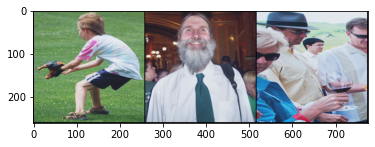

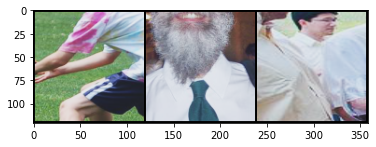

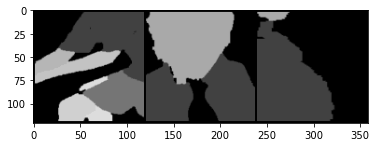

torch.float32
torch.int64


In [45]:
train_dataset_test = CustomDataset(root_image,root_label,initial_shape,target_shape)
train_loader_test = DataLoader(
    train_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)
sig = nn.Sigmoid()

for img_data_test, lbl_data_test in train_loader_test:
    #print(img_data_test.shape,lbl_data_test.shape)
    #print(lbl_data_test)
    #print(m(img_data_test))
    show_tensor_images(sig(img_data_test), size=(input_dim, initial_shape, initial_shape))
    
    show_tensor_images(crop(sig(img_data_test), torch.Size([len(img_data_test), input_dim, target_shape, target_shape])), size=(input_dim, target_shape, target_shape))
    
    show_tensor_images(lbl_data_test*blah, size=(1, target_shape, target_shape))
    print(img_data_test.dtype)
    print(lbl_data_test.dtype)
    break

In [48]:
def train_unet():
    train_dataset = CustomDataset(root_image,root_label,initial_shape,target_shape)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1
    )
    print("Data loaded, ready for training phase:")    
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0
    loss_array = []
    step_array = []
    
    for epoch in range(n_epochs):
        for real, labels in train_loader:
            
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()

            if cur_step % display_step == 0:
                loss_array.append(unet_loss.item())
                step_array.append(cur_step)
                real_img = real.detach()
                labels_img = labels.detach()
                pred_img = pred.detach()
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                #print(real.shape, labels.shape, pred.shape)
                show_tensor_images(crop(sig(real_img), torch.Size([len(real), input_dim, target_shape, target_shape])), size=(input_dim, target_shape, target_shape))
                show_tensor_images(labels_img*blah, size=(1, target_shape, target_shape))
                #print(pred.dtype, pred)
                show_tensor_images(torch.argmax(pred_img, dim=1)*blah, size=(1, target_shape, target_shape))
                #print(pred.dtype, pred)
            cur_step += 1
                    
    return unet, loss_array, step_array


Data loaded, ready for training phase:
Epoch 0: Step 0: U-Net loss: 2.945948839187622


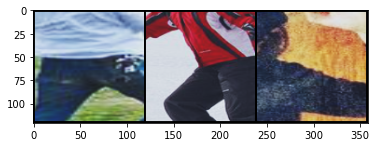

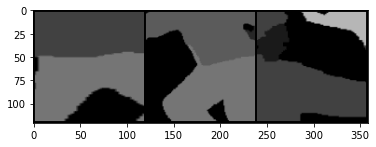

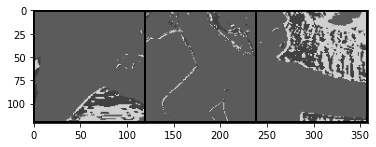

Epoch 11: Step 200: U-Net loss: 1.8279005289077759


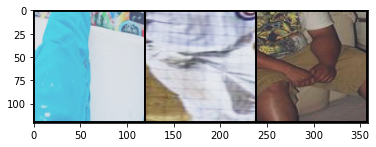

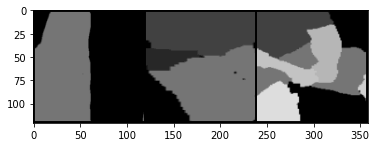

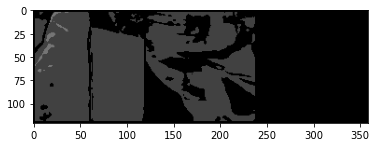

Epoch 23: Step 400: U-Net loss: 1.7133628129959106


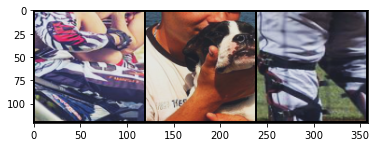

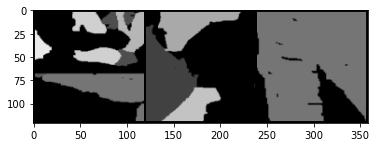

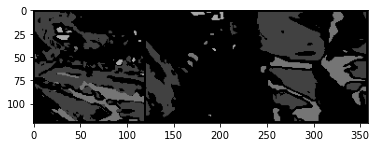

Epoch 35: Step 600: U-Net loss: 1.9654103517532349


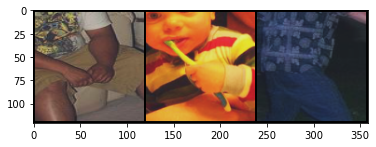

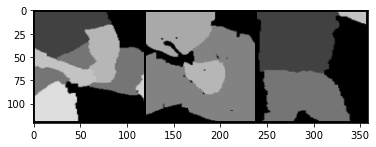

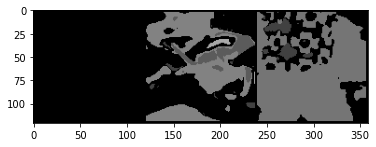

Epoch 47: Step 800: U-Net loss: 1.647064208984375


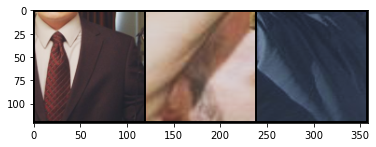

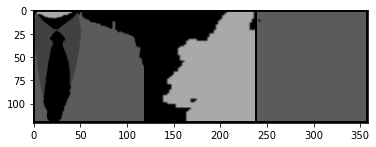

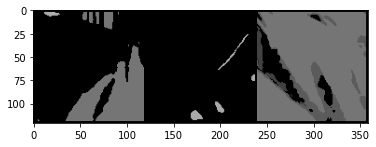

Epoch 58: Step 1000: U-Net loss: 1.6682833433151245


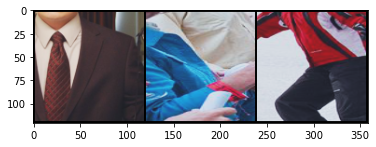

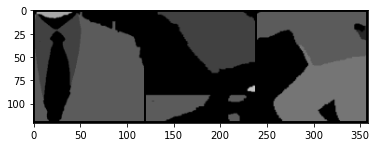

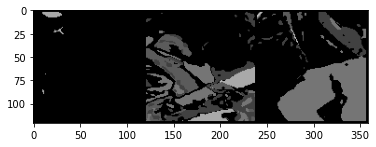

Epoch 70: Step 1200: U-Net loss: 1.555374026298523


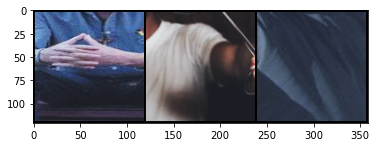

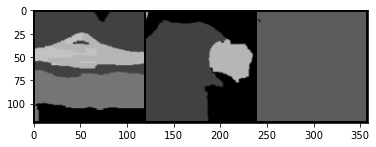

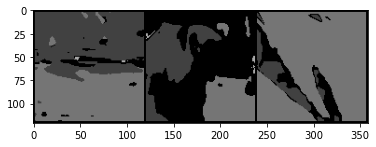

Epoch 82: Step 1400: U-Net loss: 1.2386510372161865


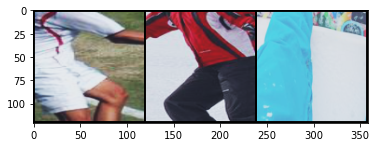

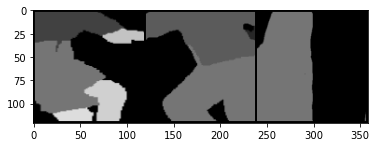

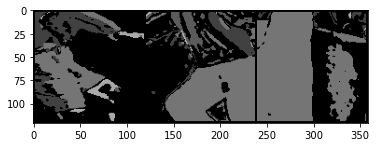

Epoch 94: Step 1600: U-Net loss: 1.6443616151809692


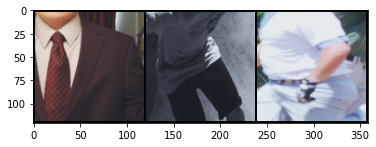

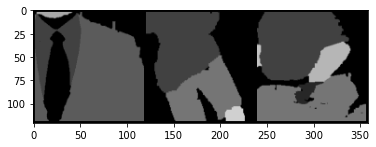

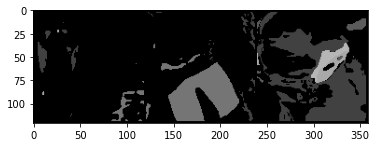

Epoch 105: Step 1800: U-Net loss: 1.5000041723251343


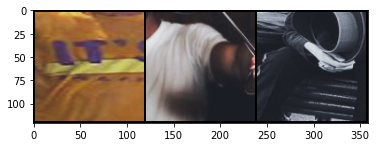

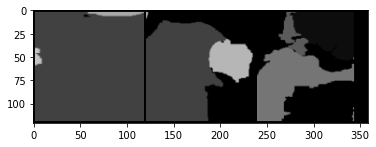

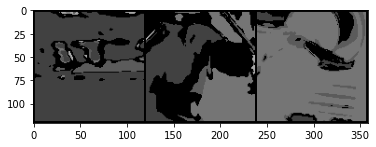

Epoch 117: Step 2000: U-Net loss: 1.6508053541183472


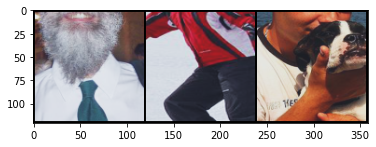

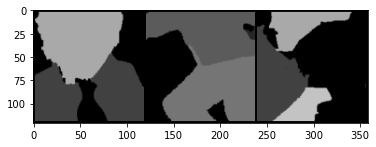

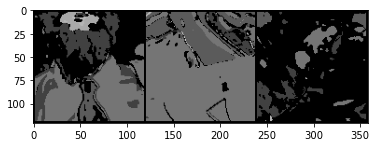

Epoch 129: Step 2200: U-Net loss: 1.7791714668273926


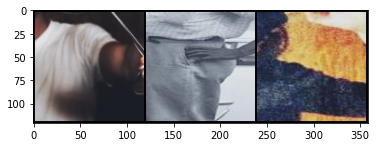

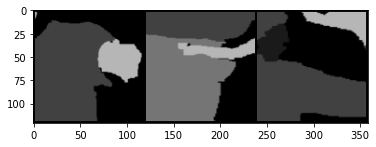

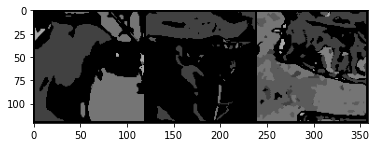

Epoch 141: Step 2400: U-Net loss: 1.2843728065490723


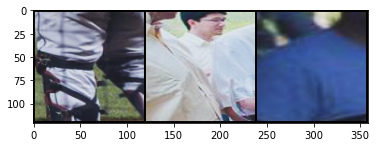

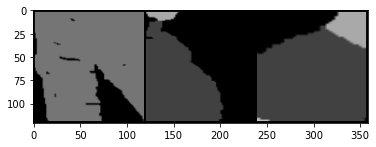

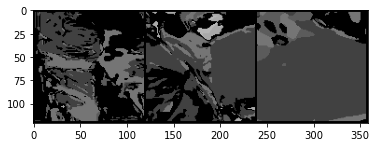

Epoch 152: Step 2600: U-Net loss: 1.5978140830993652


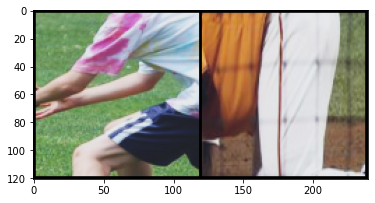

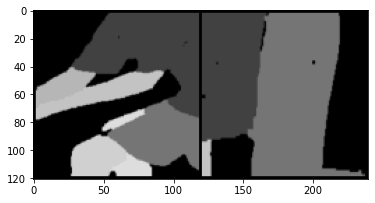

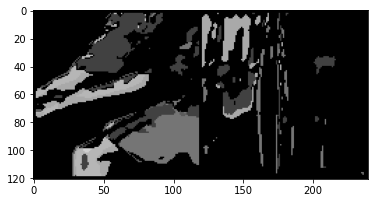

Epoch 164: Step 2800: U-Net loss: 1.0699270963668823


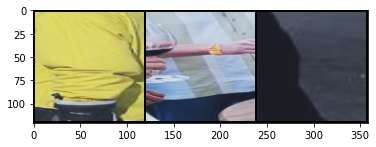

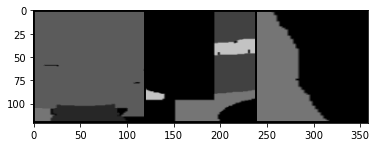

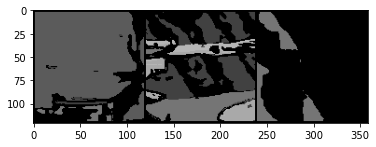

Epoch 176: Step 3000: U-Net loss: 1.6451553106307983


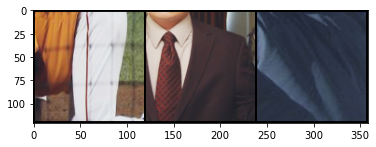

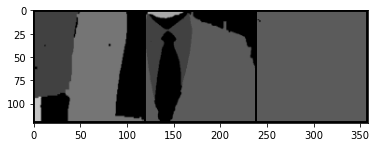

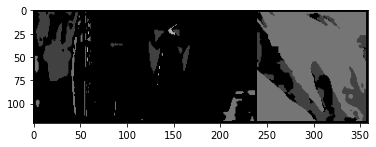

Epoch 188: Step 3200: U-Net loss: 1.5932565927505493


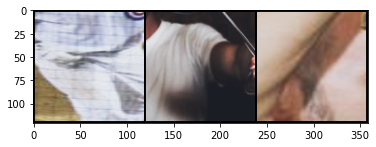

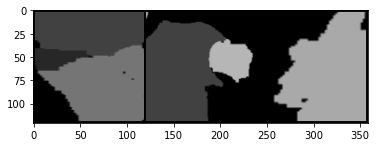

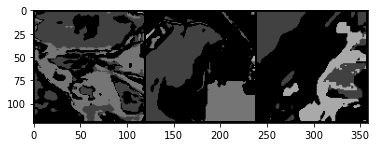

Epoch 200: Step 3400: U-Net loss: 1.3371860980987549


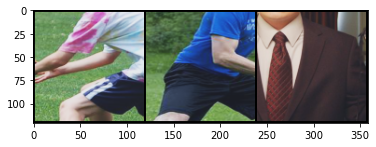

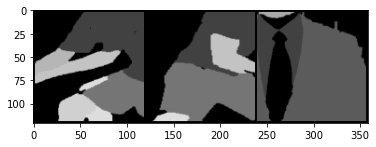

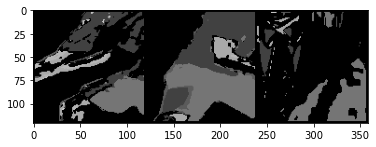

Epoch 211: Step 3600: U-Net loss: 1.4684230089187622


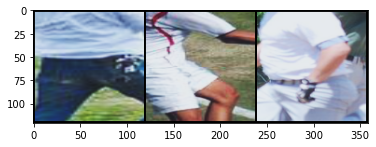

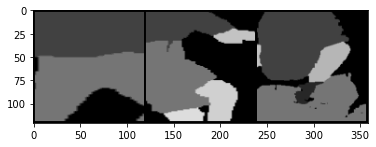

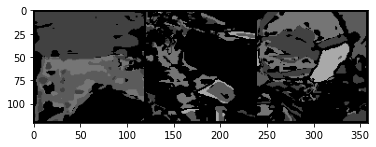

Epoch 223: Step 3800: U-Net loss: 1.3640942573547363


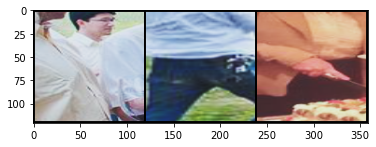

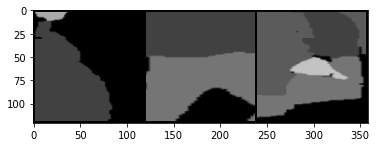

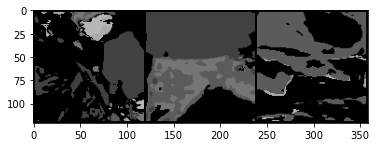

Epoch 235: Step 4000: U-Net loss: 1.5707396268844604


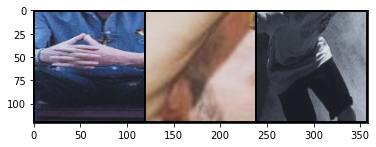

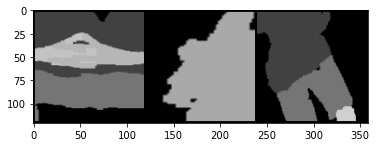

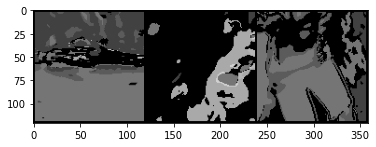

Epoch 247: Step 4200: U-Net loss: 1.877107858657837


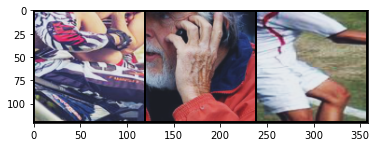

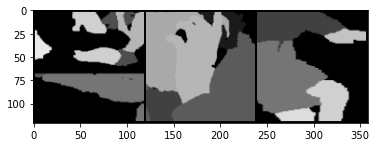

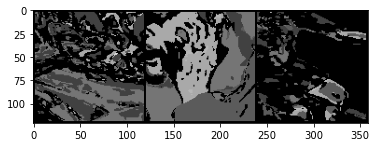

Epoch 258: Step 4400: U-Net loss: 1.7749898433685303


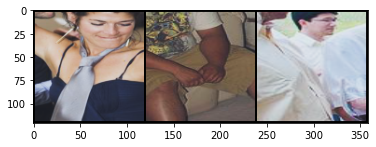

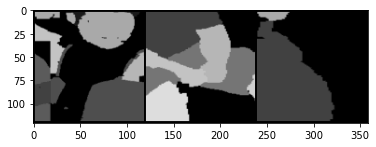

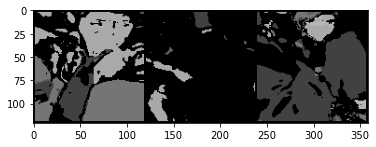

Epoch 270: Step 4600: U-Net loss: 1.04966402053833


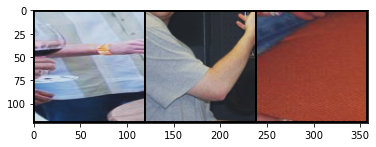

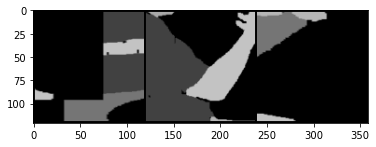

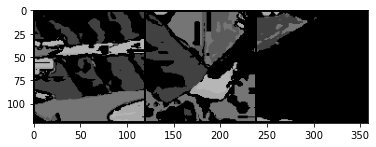

Epoch 282: Step 4800: U-Net loss: 1.6198723316192627


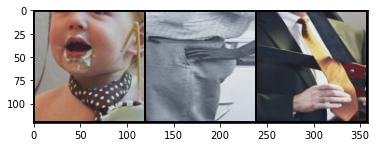

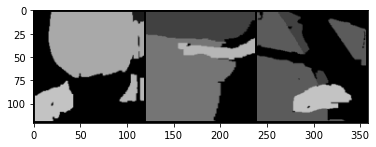

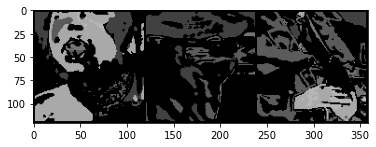

Epoch 294: Step 5000: U-Net loss: 1.3573439121246338


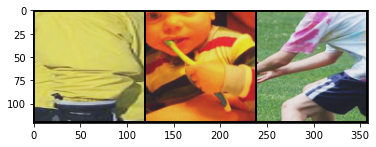

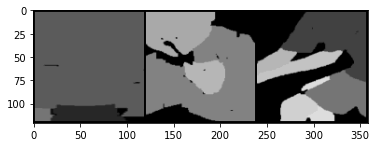

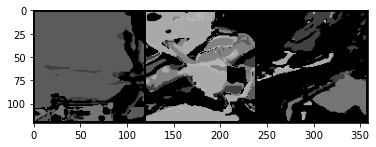

Epoch 305: Step 5200: U-Net loss: 1.839646339416504


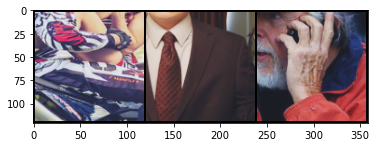

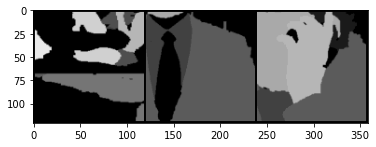

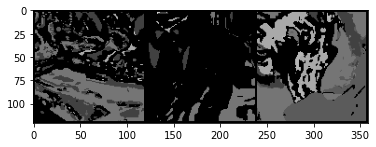

Epoch 317: Step 5400: U-Net loss: 1.4924649000167847


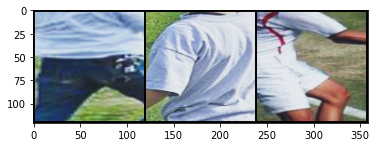

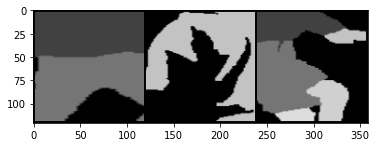

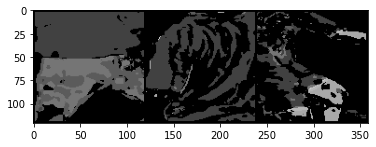

Epoch 329: Step 5600: U-Net loss: 1.3808990716934204


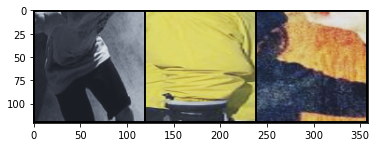

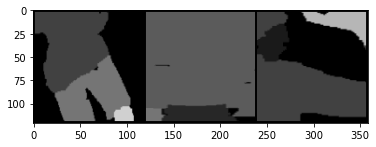

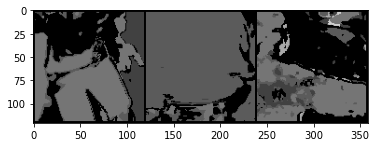

Epoch 341: Step 5800: U-Net loss: 1.7981789112091064


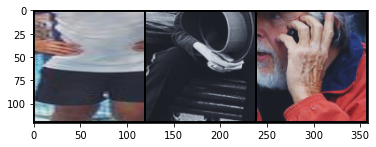

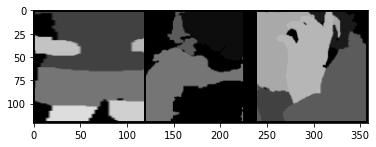

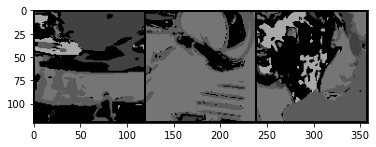

Epoch 352: Step 6000: U-Net loss: 1.7782806158065796


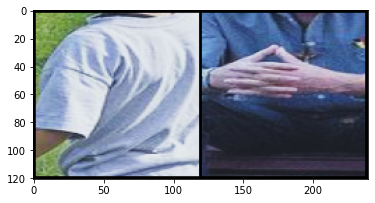

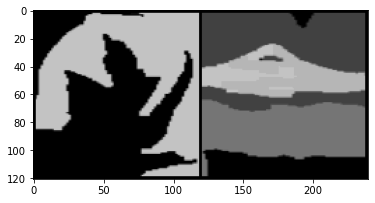

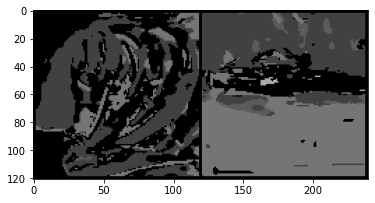

Epoch 364: Step 6200: U-Net loss: 1.5216139554977417


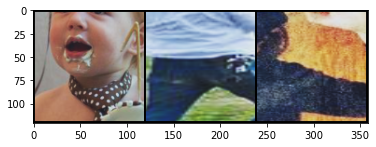

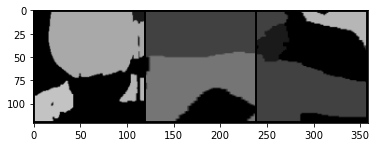

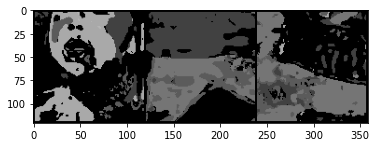

Epoch 376: Step 6400: U-Net loss: 1.1689461469650269


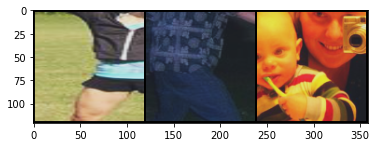

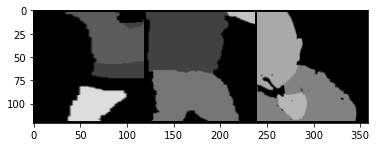

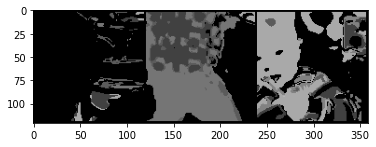

Epoch 388: Step 6600: U-Net loss: 1.5961726903915405


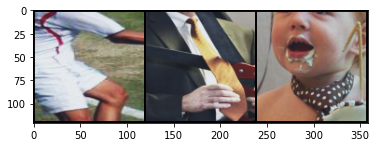

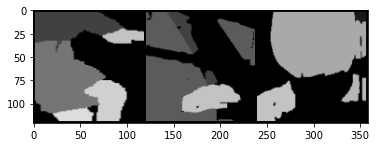

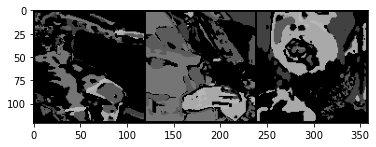

Epoch 400: Step 6800: U-Net loss: 1.6403955221176147


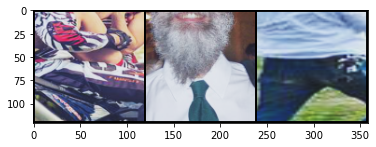

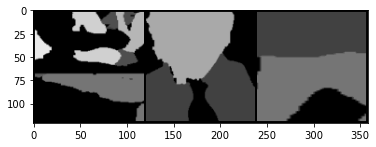

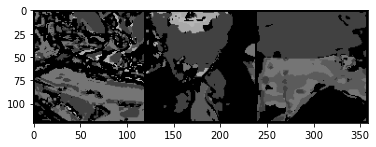

Epoch 411: Step 7000: U-Net loss: 1.212544322013855


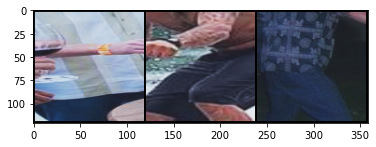

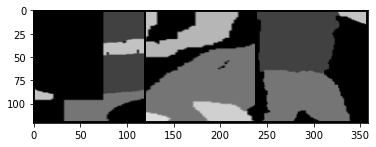

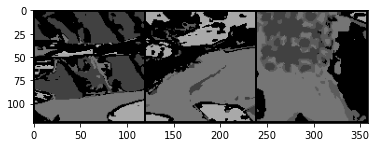

Epoch 423: Step 7200: U-Net loss: 1.0938594341278076


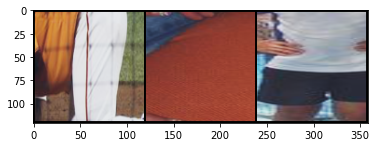

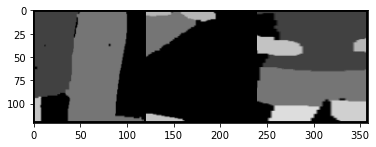

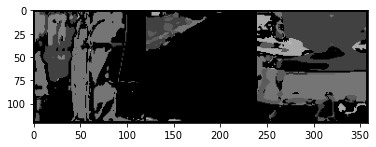

Epoch 435: Step 7400: U-Net loss: 1.5829561948776245


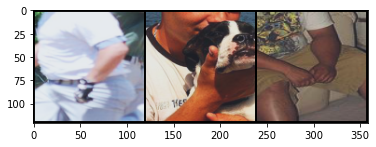

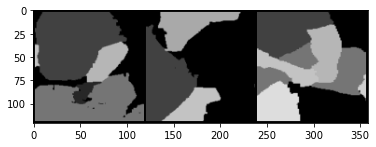

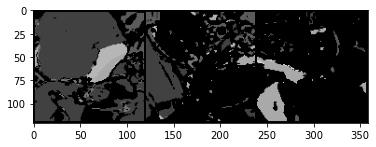

Epoch 447: Step 7600: U-Net loss: 1.2680492401123047


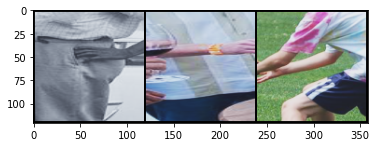

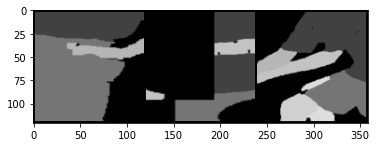

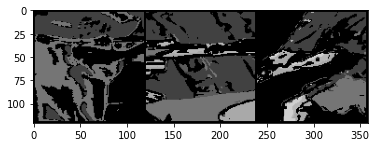

Epoch 458: Step 7800: U-Net loss: 1.338294506072998


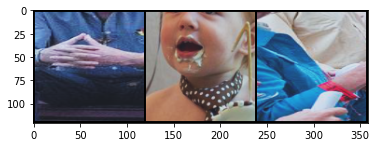

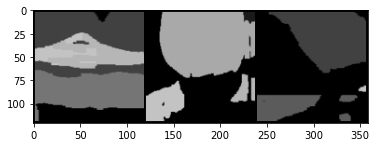

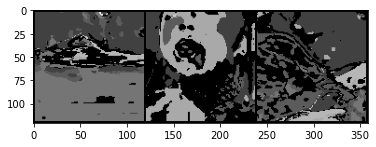

Epoch 470: Step 8000: U-Net loss: 0.8369138240814209


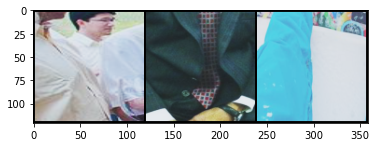

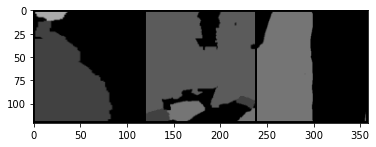

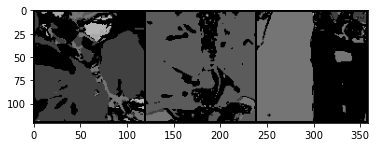

Epoch 482: Step 8200: U-Net loss: 1.6897403001785278


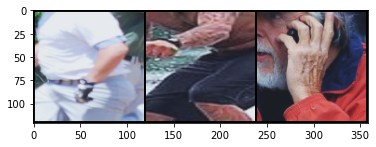

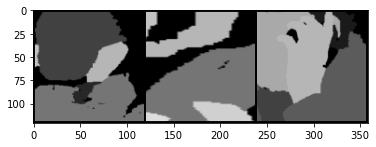

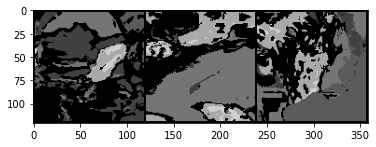

Epoch 494: Step 8400: U-Net loss: 0.852475643157959


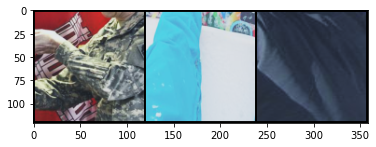

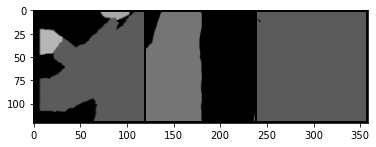

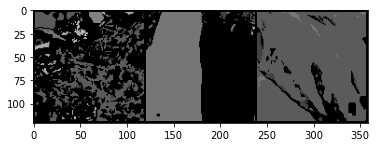

In [49]:
trained_unet, y, x = train_unet()

<function matplotlib.pyplot.show(*args, **kw)>

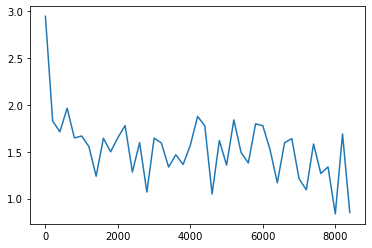

In [50]:
plt.plot(x,y)
plt.show

In [25]:
"""
train_dataset_test = CustomDataset(root_image,root_label,initial_shape,target_shape)
train_loader_test = DataLoader(
    train_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)
for img_data_test, lbl_data_test in train_loader_test:
    print(img_data_test.shape,lbl_data_test.shape)
    show_tensor_images(img_data_test, size=(1, initial_shape, initial_shape))
    #print(torch.sum(img_data_test,1).shape)
    show_tensor_images(lbl_data_test, size=(1, target_shape, target_shape))
    trained_unet.eval()
    inference_test = trained_unet(img_data_test)    
    show_tensor_images(inference_test, size=(1, target_shape, target_shape))
    break
"""

'\ntrain_dataset_test = CustomDataset(root_image,root_label,initial_shape,target_shape)\ntrain_loader_test = DataLoader(\n    train_dataset_test,\n    batch_size=batch_size,\n    shuffle=True,\n    num_workers=4\n)\nfor img_data_test, lbl_data_test in train_loader_test:\n    print(img_data_test.shape,lbl_data_test.shape)\n    show_tensor_images(img_data_test, size=(1, initial_shape, initial_shape))\n    #print(torch.sum(img_data_test,1).shape)\n    show_tensor_images(lbl_data_test, size=(1, target_shape, target_shape))\n    trained_unet.eval()\n    inference_test = trained_unet(img_data_test)    \n    show_tensor_images(inference_test, size=(1, target_shape, target_shape))\n    break\n'